In [1]:
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model

import os

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "disease/bean_dataset",
    seed=85,
    # To randomly shuffle all the images
    shuffle=True,
    # Input image size
    image_size=(256, 256),
    # Set batch size to 32
    batch_size=32
)

Found 990 files belonging to 3 classes.


In [3]:
bean_classes = dataset.class_names
bean_classes

['angular_leaf_spot', 'bean_rust', 'healthy']

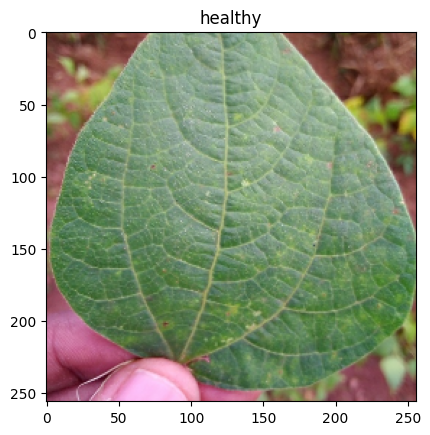

In [4]:
# Printing an image
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(bean_classes[labels_batch[0]])

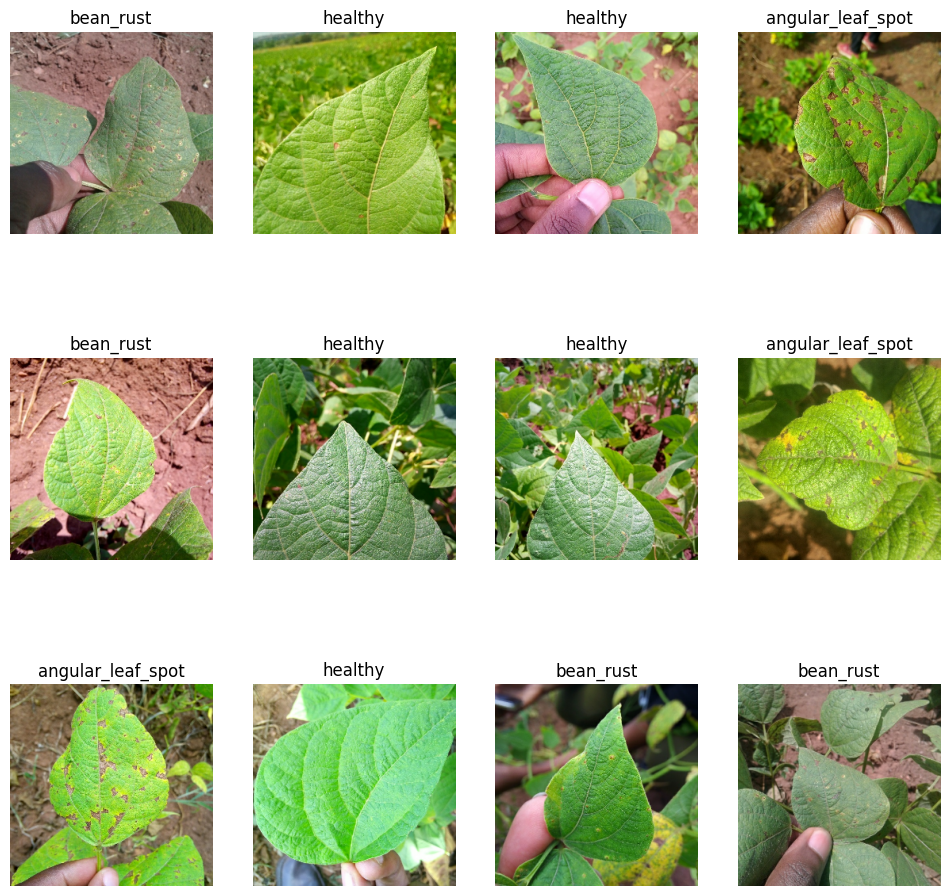

In [5]:
# First 12 images in the a batch
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

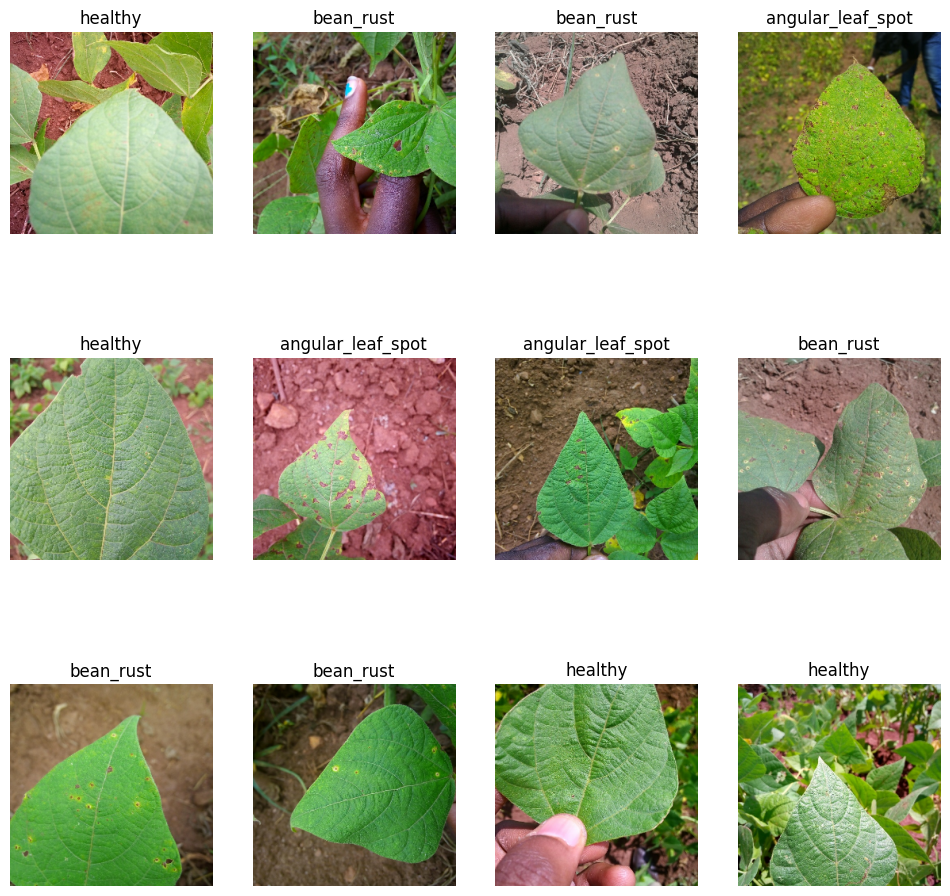

In [6]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

In [7]:
# Print the number of batches 
# In our dataset
len(dataset)

31

In [8]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    """
    Takes a dataset and splits it into train, validation and test sets. 
    """
    dataset_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=85)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_set = dataset.take(train_size)    
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [9]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [10]:
# Visualize the lenght of our splits
len(train_set), len(val_set), len(test_set)

(24, 3, 4)

In [11]:
print("Configuring the dataset for better performance")
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Configuring the dataset for better performance


In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
# Apply data augmentation to train dataset

train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
from keras.layers import Dropout
from keras import regularizers

input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
# View summary of our model parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
from keras.callbacks import EarlyStopping


earlystop_callback = EarlyStopping(
    monitor='val_loss',  
    min_delta=0.001,  
    patience=5,  
    verbose=1,  
    mode='auto')  

In [20]:
%%time
history = model.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[earlystop_callback]
)

Epoch 1/50


24/24 [==============================] - 103s 4s/step - loss: 1.8045 - accuracy: 0.3316 - val_loss: 1.6582 - val_accuracy: 0.4271
Epoch 2/50
24/24 [==============================] - 75s 3s/step - loss: 1.5271 - accuracy: 0.4478 - val_loss: 1.3828 - val_accuracy: 0.4896
Epoch 3/50
24/24 [==============================] - 79s 3s/step - loss: 1.3008 - accuracy: 0.5300 - val_loss: 1.5817 - val_accuracy: 0.3021
Epoch 4/50
24/24 [==============================] - 65s 3s/step - loss: 1.2231 - accuracy: 0.5104 - val_loss: 1.2581 - val_accuracy: 0.3958
Epoch 5/50
24/24 [==============================] - 64s 3s/step - loss: 1.1207 - accuracy: 0.5457 - val_loss: 1.1423 - val_accuracy: 0.5104
Epoch 6/50
24/24 [==============================] - 61s 3s/step - loss: 1.0407 - accuracy: 0.5875 - val_loss: 0.8599 - val_accuracy: 0.7500
Epoch 7/50
24/24 [==============================] - 62s 3s/step - loss: 0.9650 - accuracy: 0.6332 - val_loss: 1.1420 - val_accuracy: 0.4688
Epoch 8/50
24/24 [============

In [21]:
# Evaluate model performance on test set
scores = model.evaluate(test_set)

4/4 [==============================] - 6s 514ms/step - loss: 0.4775 - accuracy: 0.7891


In [22]:
scores

[0.4775177836418152, 0.7890625]

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

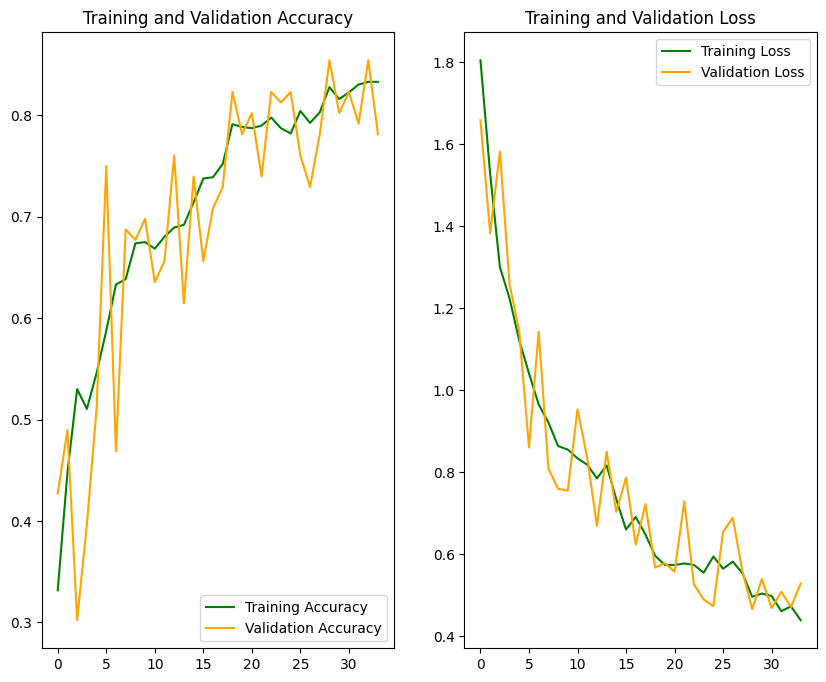

In [25]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(range(34), acc, color='green', label='Training Accuracy')
plt.plot(range(34), val_acc, color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(34), loss, color='green', label='Training Loss')
plt.plot(range(34), val_loss,color='orange', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Function that takes an image as an input
# And gives us the confidence score of the prediction

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 47ms/step


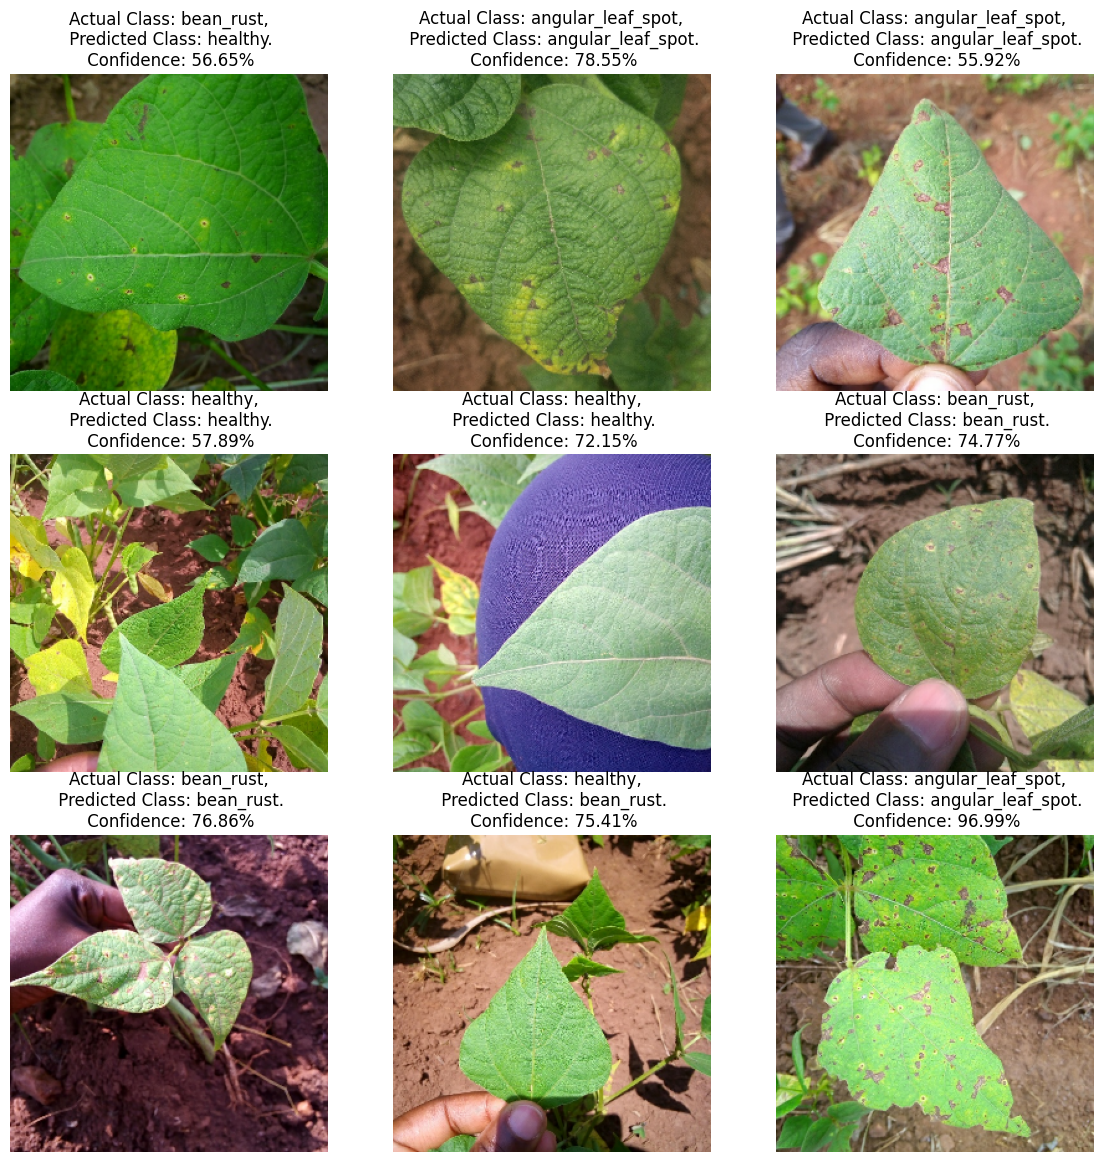

In [27]:
# Let's predict the first 9 images in the first batch
class_names = bean_classes

plt.figure(figsize=(14, 14))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual Class: {actual_class},\n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [29]:
model.save(os.path.join('models', 'bean_disease_mode.h5'))

In [30]:
predict(model, '')

1/1 [==============================] - 0s 46ms/step


('angular_leaf_spot', 96.99)